In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import json
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import torch

In [3]:
df_train = pd.read_json('/content/drive/MyDrive/ML hw5 data/train.json')
df_train.set_index('cuisine', inplace=True)
# df_train.drop(columns=['id'], inplace=True)
df_test = pd.read_json('/content/drive/MyDrive/ML hw5 data/test.json')
# df_test.drop(columns=['id'], inplace=True)




Text(0.5, 1.0, "value counts of each cuisine's ingredient num")

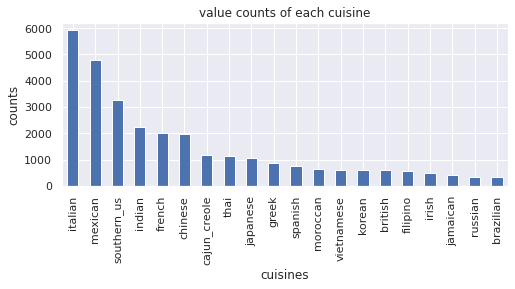

<Figure size 1080x288 with 0 Axes>

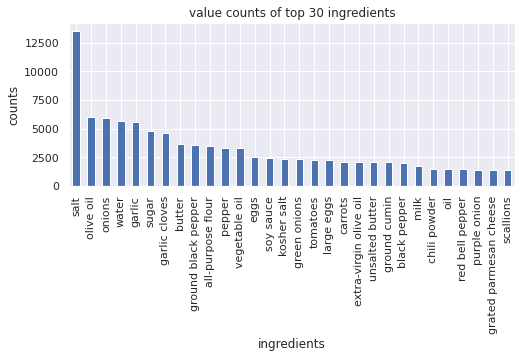

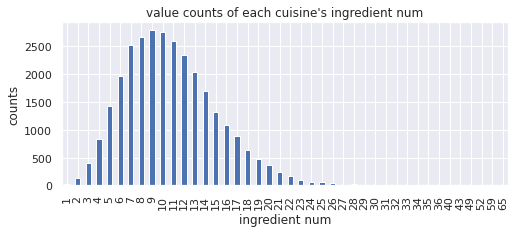

In [4]:
# cuisines' value counts
df_train.index.value_counts().plot(kind='bar', figsize=(8,3))
plt.xlabel('cuisines')
plt.ylabel('counts')
plt.title('value counts of each cuisine')

# ingredients' value counts
plt.figure(figsize=(15,4))
ingredients_vc = {}
for row in df_train['ingredients']:
    for ingredient in row:
        if ingredient in ingredients_vc:
            ingredients_vc[ingredient] += 1
        else:
            ingredients_vc[ingredient] = 1
# print(ingredients_vc)
ingredients_vc = sorted(ingredients_vc.items(), key=lambda x:x[1], reverse=True)
ingredients_vc = pd.DataFrame(ingredients_vc[0:30], columns=['ingredients', 'value counts'])
ingredients_vc.set_index('ingredients', inplace=True)
ingredients_vc.plot(kind='bar', figsize=(8,3), legend=False)
plt.xlabel('ingredients')
plt.ylabel('counts')
plt.title('value counts of top 30 ingredients')


ingredient_num_vc = {}
for row in df_train['ingredients']:
    ingredient_num = len(row)
    if ingredient_num in ingredient_num_vc:
        ingredient_num_vc[ingredient_num] += 1
    else:
        ingredient_num_vc[ingredient_num] = 1
# print(ingredient_num_vc)
ingredient_num_vc = sorted(ingredient_num_vc.items(), key=lambda x:x[0])
ingredient_num_vc = pd.DataFrame(ingredient_num_vc, columns=['ingredient_num', 'value counts'])
ingredient_num_vc.set_index('ingredient_num', inplace=True)
ingredient_num_vc.plot(kind='bar', figsize=(8,3), legend=False)
plt.xlabel('ingredient num')
plt.ylabel('counts')
plt.title('value counts of each cuisine\'s ingredient num')

In [5]:
all_train_label = df_train.index.values

all_cuisines = set(all_train_label)
all_ingredients = set()

print(all_cuisines)

for row in df_train['ingredients']:
  for ingredient in row:
    ingredient = ingredient.split(' ')
    for i, word in enumerate(ingredient):
          ingredient[i] = word.lower()
    
    all_ingredients = all_ingredients.union(set(ingredient))

cuisines_map = {}
ingredients_map = {}
for i, cuisine in enumerate(all_cuisines):
  cuisines_map[cuisine] = i
for i, ingredient in enumerate(all_ingredients):
  ingredients_map[ingredient] = i

# print(cuisine_names)
# print(train_data)

{'mexican', 'brazilian', 'chinese', 'southern_us', 'jamaican', 'indian', 'thai', 'greek', 'russian', 'japanese', 'spanish', 'french', 'moroccan', 'british', 'korean', 'filipino', 'irish', 'cajun_creole', 'italian', 'vietnamese'}


In [6]:
def ingredients_list_to_string(df):
    return [' '.join(ingredients) for ingredients in df['ingredients']]

all_train_data = np.array(ingredients_list_to_string(df_train))
test_data = np.array(ingredients_list_to_string(df_test))

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

all_train_data = Pipeline([('count', CountVectorizer(vocabulary=ingredients_map)),
                 ('tfid', TfidfTransformer())]).fit_transform(all_train_data)
all_train_data = all_train_data.toarray()
all_train_data = all_train_data.astype('float')

test_data = Pipeline([('count', CountVectorizer(vocabulary=ingredients_map)),
                 ('tfid', TfidfTransformer())]).fit_transform(test_data)
test_data = test_data.toarray()
test_data = test_data.astype('float')

# print(type(X))
# print(train_data.toarray().shape)

# print(type(train_label))

In [8]:
from sklearn.preprocessing import OneHotEncoder

for i, label in enumerate(all_train_label):
    all_train_label[i] = cuisines_map[label]
all_train_label_idx = all_train_label.copy()
all_train_label_idx = all_train_label_idx.astype('float')

onehotencoder = OneHotEncoder()
all_train_label = np.reshape(all_train_label, (len(all_train_label),1))
all_train_label = onehotencoder.fit_transform(all_train_label).toarray()
print(all_train_label.shape)

# train_label = train_label.astype('float')
print(all_train_label_idx.shape)
print(all_train_label.shape)

(29774, 20)
(29774,)
(29774, 20)


In [9]:
from sklearn.model_selection import train_test_split
train_data, validate_data, train_label, validate_label, train_label_idx, validate_label_idx  = train_test_split(all_train_data, all_train_label, all_train_label_idx, test_size=0.3, shuffle=True)
print(train_data.shape)
print(validate_data.shape)
print(train_label.shape)
print(validate_label.shape)
print(test_data.shape)

(20841, 3000)
(8933, 3000)
(20841, 20)
(8933, 20)
(10000, 3000)


In [10]:
from keras import models
from keras import layers
from keras import losses

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(3000,)))
model.add(layers.Dense(20, activation='softmax'))

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96032     
                                                                 
 dense_1 (Dense)             (None, 20)                660       
                                                                 
Total params: 96,692
Trainable params: 96,692
Non-trainable params: 0
_________________________________________________________________


In [11]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(train_data, train_label, epochs=25, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/25
456/456 [==============================] - 3s 6ms/step - loss: 2.0451 - accuracy: 0.4552 - val_loss: 1.4359 - val_accuracy: 0.6069
Epoch 2/25
456/456 [==============================] - 2s 5ms/step - loss: 1.1989 - accuracy: 0.6684 - val_loss: 1.0685 - val_accuracy: 0.6977
Epoch 3/25
456/456 [==============================] - 2s 5ms/step - loss: 0.9277 - accuracy: 0.7408 - val_loss: 0.9248 - val_accuracy: 0.7364
Epoch 4/25
456/456 [==============================] - 2s 5ms/step - loss: 0.7864 - accuracy: 0.7788 - val_loss: 0.8551 - val_accuracy: 0.7534
Epoch 5/25
456/456 [==============================] - 2s 5ms/step - loss: 0.6954 - accuracy: 0.8057 - val_loss: 0.8148 - val_accuracy: 0.7622
Epoch 6/25
456/456 [==============================] - 2s 5ms/step - loss: 0.6295 - accuracy: 0.8212 - val_loss: 0.7894 - val_accuracy: 0.7662
Epoch 7/25
456/456 [==============================] - 3s 5ms/step - loss: 0.5784 - accuracy: 0.8362 - val_loss: 0.7766 - val_accuracy: 0.7708
Epoch 

In [12]:
def plot_confusion_matrix(mat, title, xyticklabels, pos=None):
    if pos != None:
        plt.subplot(pos)
    sns.heatmap(mat.T, square=True, annot=True, fmt='.2f', cbar=False,
                xticklabels=xyticklabels, yticklabels=xyticklabels, cmap=plt.cm.Greens)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title(title)  
def plot_performance(precision, recall, accuracy, index):
    df = list(zip(precision, recall)) 
    table = pd.DataFrame( df, index,
        columns=['Precision', 'Recall'])
    print(table)
    print('accuracy      {:.6f}'.format(accuracy))

In [13]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
validate_predict = model.predict(validate_data)
print(validate_predict.shape)
print(validate_predict[0])
validate_predict_idx = np.zeros(validate_predict.shape[0])
for i, row in enumerate(validate_predict):
  validate_predict_idx[i] = np.where(row == row.max())[0][0]


(8933, 20)
[1.5792495e-03 9.1625283e-05 5.3388241e-04 2.7502389e-03 1.5347554e-04
 2.8835755e-04 5.3737407e-05 7.8021217e-04 1.0768267e-03 4.4325901e-05
 2.1516921e-03 4.4831387e-03 1.9929629e-04 2.1822323e-04 2.8793806e-05
 1.0127492e-03 2.0277830e-04 2.3331828e-02 9.6059674e-01 4.2275203e-04]


In [14]:
print(validate_predict_idx)

[18.  8.  3. ... 12. 18. 18.]


In [15]:
mat = confusion_matrix(validate_label_idx, validate_predict_idx)

precision = metrics.precision_score(validate_label_idx, validate_predict_idx, average=None)
recall = metrics.recall_score(validate_label_idx, validate_predict_idx, average=None)
accuracy = metrics.accuracy_score(validate_label_idx, validate_predict_idx)

    Precision    Recall
0    0.891421  0.927476
1    0.807692  0.424242
2    0.763040  0.849088
3    0.679666  0.760125
4    0.781818  0.735043
5    0.858824  0.892966
6    0.733333  0.728707
7    0.774775  0.661538
8    0.558442  0.390909
9    0.788530  0.689655
10   0.539773  0.448113
11   0.599010  0.581731
12   0.806061  0.730769
13   0.481752  0.370787
14   0.754601  0.664865
15   0.728682  0.556213
16   0.568000  0.473333
17   0.743363  0.684783
18   0.810081  0.877551
19   0.662338  0.579545
accuracy      0.765924


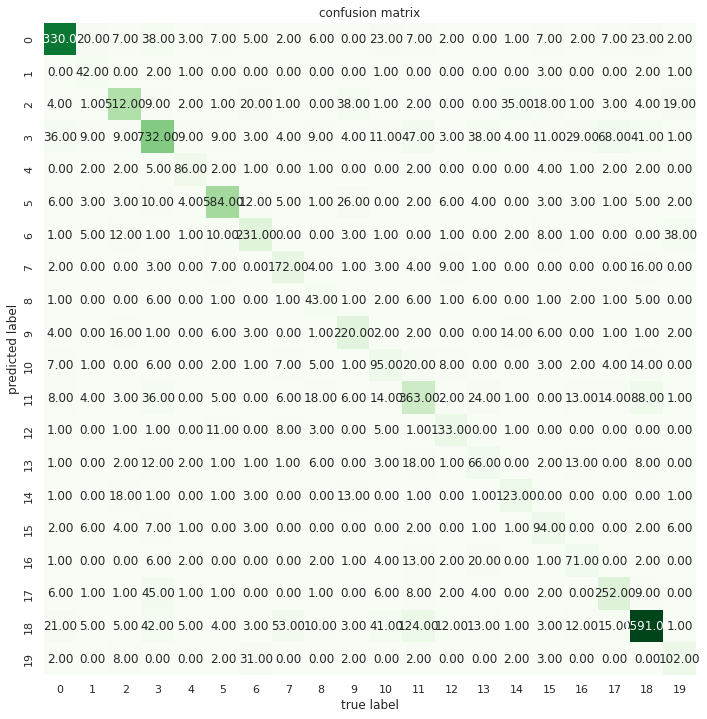

In [16]:
plt.figure(figsize=(12,12))
xyticklabels = [i for i in range(len(all_cuisines))]
plot_confusion_matrix(mat, 'confusion matrix', xyticklabels, pos=None)

plot_performance(precision, recall, accuracy, xyticklabels)

In [17]:
model.fit(all_train_data, all_train_label, epochs=25)

Epoch 1/25
931/931 [==============================] - 3s 3ms/step - loss: 0.5918 - accuracy: 0.8211
Epoch 2/25
931/931 [==============================] - 3s 3ms/step - loss: 0.5436 - accuracy: 0.8365
Epoch 3/25
931/931 [==============================] - 3s 3ms/step - loss: 0.5126 - accuracy: 0.8433
Epoch 4/25
931/931 [==============================] - 3s 3ms/step - loss: 0.4886 - accuracy: 0.8511
Epoch 5/25
931/931 [==============================] - 3s 3ms/step - loss: 0.4688 - accuracy: 0.8568
Epoch 6/25
931/931 [==============================] - 3s 3ms/step - loss: 0.4522 - accuracy: 0.8606
Epoch 7/25
931/931 [==============================] - 3s 3ms/step - loss: 0.4363 - accuracy: 0.8643
Epoch 8/25
931/931 [==============================] - 3s 3ms/step - loss: 0.4236 - accuracy: 0.8690
Epoch 9/25
931/931 [==============================] - 3s 3ms/step - loss: 0.4114 - accuracy: 0.8738
Epoch 10/25
931/931 [==============================] - 3s 3ms/step - loss: 0.4010 - accuracy: 0.8753

In [18]:
test_predict = model.predict(test_data)
print(test_predict.shape)
print(test_predict[0])
test_predict_idx = np.zeros(test_predict.shape[0])
for i, row in enumerate(test_predict):
  test_predict_idx[i] = np.where(row == row.max())[0][0]


(10000, 20)
[2.70406844e-07 4.18754559e-10 1.08388675e-04 8.91064023e-09
 5.02724085e-10 1.49195188e-07 7.19687114e-06 1.53982762e-06
 8.06435363e-09 1.42775614e-08 1.07543030e-06 4.25504222e-05
 4.93971370e-08 1.62411662e-09 2.24558026e-08 3.83357524e-08
 2.40893911e-07 6.22380156e-08 9.99838352e-01 1.85985218e-08]


In [19]:
test_id = df_test['id'].values


# list out keys and values separately
key_list = list(cuisines_map.keys())
val_list = list(cuisines_map.values())




output = 'id,Category\n'
for i in range(len(test_id)):
  output += str(test_id[i])
  output += ','
  output += key_list[val_list.index(test_predict_idx[i])]
  output += '\n'

f = open("/content/drive/MyDrive/ML hw5 data/y_test.csv", "w")
f.write(output)
f.close()